In [69]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data

import viz_weights
%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
style.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results from a directory

In [56]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/sweep_full_high_seeds'
fnames = sorted([fname for fname in os.listdir(out_dir) 
                 if 'mnist' in fname and 
                 'numlays=4' in fname and 
                 'batchsize=100' in fname])
weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if fname.startswith('weights')]
results_weights = pd.concat(weights_list, axis=1).T.infer_objects()

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights')]
results = pd.concat(results_list, axis=1).T.infer_objects()

save_dir = 'results_weights'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
print('loaded', results_weights.shape[0], 'runs')

100%|██████████| 182/182 [00:01<00:00, 101.37it/s]

loaded 91 runs


# set the params

In [57]:
# filter out certain things
results_weights = results_weights[results_weights['shuffle_labels'] == False]

In [115]:
row = 7
epoch = 151
lay = 'fc.0.weight'
num_to_plot = 225

# derivatives
# print(results_weights.keys())
run = results_weights.iloc[row]


print('results_weights', 'lr', run['lr'], 'opt', run['optimizer'], 'shuffle_labels', run['shuffle_labels'])

'''
run_accs = results.iloc[row]

print('results', 'lr', run_accs['lr'], 'opt', run_accs['optimizer'], 'shuffle_labels', run_accs['shuffle_labels'])
plt.plot(run_accs['its'], run_accs['accs_train'])
print(run_accs['accs_train'][:30])
'''

# cast variables to correct types
run['num_layer'] = int(run['num_layers'])
run['hidden_size'] = int(run['hidden_size'])

results_weights lr 0.1 opt sgd shuffle_labels False


### plot weights

dict_keys([0.0, 32.0, 132.0, 112.0, 151.0, 72.0, 52.0, 92.0, 12.0])


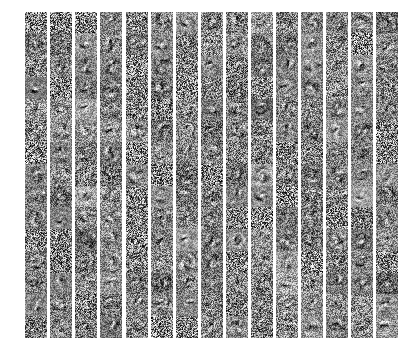

In [59]:
# keys are epochs, vals are dicts of all weights
weights_dict_dict = run['weights']

# keys are layers, vals are weight values
print(weights_dict_dict.keys())
weights_dict = weights_dict_dict[epoch]

# matrix of weights (output x input)
w = weights_dict[lay]

viz_weights.plot_weights(w[:num_to_plot])
plt.show()

### reload the model

In [60]:
# load model
train_loader, test_loader, model, trans = data.get_data_and_model(run)

# load in weights
print(sorted(weights_dict.keys()), sorted(model.state_dict().keys()))
weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict.items()}
model.load_state_dict(weights_dict_tensors)
model = model.cuda()

['fc.0.bias', 'fc.0.weight', 'fc.1.bias', 'fc.1.weight', 'fc.2.bias', 'fc.2.weight', 'fc.3.bias', 'fc.3.weight'] ['fc.0.bias', 'fc.0.weight', 'fc.1.bias', 'fc.1.weight', 'fc.2.bias', 'fc.2.weight', 'fc.3.bias', 'fc.3.weight']


### reload the data

In [61]:
# need to load like this to ensure transformation applied
data_list_train = [batch for batch in train_loader]
train_data_list = [batch[0] for batch in data_list_train]
train_data = np.vstack(train_data_list)
X_train = torch.Tensor(train_data).float().cuda()
Y_train = np.hstack([batch[1] for batch in data_list_train])

data_list_test = [batch for batch in test_loader]
test_data_list = [batch[0] for batch in data_list_test]
test_data = np.vstack(test_data_list)
X_test = torch.Tensor(test_data).float().cuda()
Y_test = np.hstack([batch[1] for batch in test_data_list])

### check the acc

In [63]:
preds = model(Variable(X_train)).data.cpu().numpy().argmax(axis=1)
accs = preds==Y_train
print('mean acc', np.mean(accs))

mean acc 0.9834166666666667


Text(0, 0.5, 'acc')

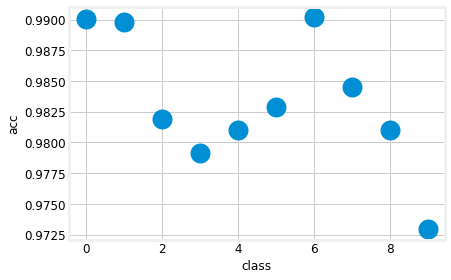

In [72]:
mean_accs = np.zeros(10)
for c in range(10):
    idxs_c = Y_train == c
    mean_accs[c] = np.mean(accs[idxs_c])
plt.plot(range(10), mean_accs, 'o')
plt.xlabel('class')
plt.ylabel('acc')

### viz weights

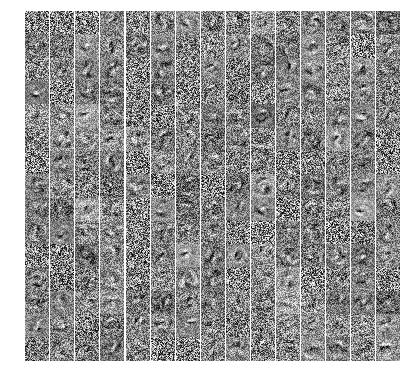

In [75]:
W = model.state_dict()['fc.0.weight'].cpu().numpy()
viz_weights.plot_weights(W[:num_to_plot])

mean max corr 0.17790407


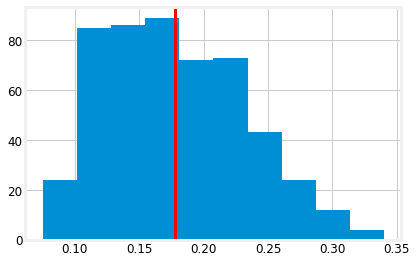

In [111]:
# gives max corr between nearest neighbor and any point
# works clearly for 1st layer, for 2nd layers have to generate a "filter" by doing max activation

# X is N x num_pixels
# W is num_filters x num_pixels
# returns max_corr for each filter
def max_corr_input(X, W):
#     print(X.shape, W.shape)
    X = X / (np.sum(np.abs(X)**2, axis=1)**(1./2))[:, np.newaxis]
    W = W / (np.sum(np.abs(W)**2, axis=1)**(1./2))[:, np.newaxis]
    Z = np.abs(W @ X.T)
    max_corr = np.max(Z, axis=1)
    return max_corr

X = X_train.cpu().numpy().reshape(X_train.shape[0], -1)
max_corr = max_corr_input(X, W)
print('mean max corr', np.mean(max_corr))
plt.hist(max_corr)
plt.axvline(np.mean(max_corr), color='red')
plt.show()